In [1]:
import subprocess, sys,json, os

In [2]:
import pandas as pd
import numpy as np

In [3]:
import skimage.io

In [4]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
#from tensorflow.python.keras.applications import ResNet50
import tensorflow
tensorflow.__version__

'2.2.0'

In [6]:
from tensorflow.keras.models import model_from_json, save_model, load_model

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [8]:
from panda_bvv_config import *


In [19]:
# image_sizey = 256
# image_sizex = 256
test_folder_wrapper = os.path.join(base_path, 'rsnet_256_png_weights')
# BS = 32
#test_len = len(os.listdir(test_no_classes_cnn))

In [21]:
test_datagen = ImageDataGenerator(rescale = 1/255)

### Ground truth labels, data ###

#### 1. based on dataframe approach - easy and logical ####

In [10]:
labels_perm = train_labels.sample(frac = 1, random_state = npseed)
test_cnn_labels = labels_perm[9400:]

In [11]:
test_cnn_labels[:20]

,image_id,data_provider,isup_grade,gleason_score,PH_size1,PW_size1,PH_size2,PW_size2,PH_mask_size2,PW_mask_size2,PH_mask_size1,PW_mask_size1
8767,d3a5775345ddc4976944ff1941709ef0,karolinska,0,0+0,7296.0,5376.0,1824.0,1344.0,1824,1344,7296.0,5376.0
9336,e20c73041c5c5ac83c20a7c669f46e9a,radboud,3,4+3,3712.0,1344.0,928.0,336.0,928,336,3712.0,1344.0
5848,8f8d20fc6e9b6aa3b145e359e104eac4,radboud,3,4+3,6720.0,2560.0,1680.0,640.0,1680,640,6720.0,2560.0
4296,6ac2095c7968fa30ab6c5dc7d1ed5121,karolinska,0,0+0,7680.0,6016.0,1920.0,1504.0,1920,1504,7680.0,6016.0
2267,389758c9e3aad00e774d581150f372db,radboud,3,4+3,7296.0,1728.0,1824.0,432.0,1824,432,7296.0,1728.0
4147,66f04788a17915feba394290384e13a4,radboud,4,4+4,1856.0,1216.0,464.0,304.0,464,304,1856.0,1216.0
419,0abc61a1bc7abe47b9e44a9f69979eb0,karolinska,2,3+4,8832.0,6912.0,2208.0,1728.0,2208,1728,8832.0,6912.0
10507,fd8928cd1f06f33ff00e32f19c58abd3,radboud,5,5+4,3968.0,1024.0,992.0,256.0,992,256,3968.0,1024.0
9248,dfae643568b01d1f4ad5d86bac2f7994,radboud,2,3+4,7232.0,4544.0,1808.0,1136.0,1808,1136,7232.0,4544.0
10410,fb80c40073a4016bf384f408ec048f55,radboud,3,4+3,3072.0,3008.0,768.0,752.0,768,752,3072.0,3008.0


In [18]:
def prepare_df_data(test_df = test_cnn_labels,
                       data_fold = test_folder_wrapper):
    test_data = []
    test_labels = []
    df_f = []
    for i,row in enumerate(test_df.iterrows()): 
        img_num = row[1]['image_id']
        biopsy = skimage.io.imread(os.path.join(data_fold, 'testf',img_num + '.png'))
        test_data.append(biopsy)
        test_labels.append(row[1]['isup_grade'])
        df_f.append(img_num)
                           
    return np.array(test_data), np.array(test_labels), df_f

In [20]:
test_data_df, test_labels_df, df_f = prepare_df_data()

In [23]:
#np.savez(os.path.join(model_path, 'rsnet_256_png_weights','ground256simple'), test_data = test_data, test_labels=test_labels)

In [67]:
test_labels_df

array([0, 3, 3, ..., 2, 2, 0])

In [32]:
df_f[:3]

['d3a5775345ddc4976944ff1941709ef0',
 'e20c73041c5c5ac83c20a7c669f46e9a',
 '8f8d20fc6e9b6aa3b145e359e104eac4']

In [34]:
#test_data_df[0]

In [35]:
sum(sum(test_data_df[1]))

array([247,   6,  45], dtype=uint8)

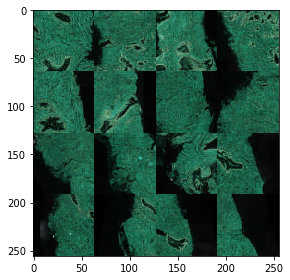

In [36]:
skimage.io.imshow(test_data_df[1])

In [37]:
len(test_data_df)

1216

#### 2. based on files-from-folder approach - counter-imtuitive, we leave it as a shaggy dog  story ####

In [ ]:
test_generator = test_datagen.flow_from_directory(
                                test_folder_wrapper, 
                                target_size=(image_sizey, image_sizex),
                                color_mode="rgb",
                                batch_size=1,
                                shuffle = False,
                                class_mode='categorical')

In [ ]:
fnames = test_generator.filenames

In [230]:
#example:
#fnames[0].split('/')[1].split('.')[0]

In [197]:
def prepare_test_data_folder(test_df = test_cnn_labels,
                       file_list = fnames[:3],
                       data_fold = test_folder_wrapper):
    test_data = []
    test_labels = []
    filenames = []
    for file in file_list:
        img_name = file.split('/')[1].split('.')[0]       
        print(img_name)
        print(sum(sum(skimage.io.imread(os.path.join(train_size2, img_name +'.jpg')))))
        label = list(test_df.loc[test_df.image_id == img_name]['isup_grade'])[0]

        biopsy = skimage.io.imread(os.path.join(data_fold, file))
        test_data.append(biopsy)
        test_labels.append(label)
        filenames.append(img_name)
    return np.array(test_data), np.array(test_labels), filenames

In [229]:
#prepare_test_data_folder()

In [143]:
#frankly speaking, we do not need test data, labels only
test_data_folder, test_labels_folder, f_list = prepare_test_data()
test_labels[:10]

array([1, 5, 1, 5, 4, 2, 0, 3, 0, 5])

In [144]:
f_list[:5]

['0032bfa835ce0f43a92ae0bbab6871cb',
 '00928370e2dfeb8a507667ef1d4efcbb',
 '00e6511435645e50673991768a713c66',
 '01a9472f2b061f80bb7c125dfa9771e5',
 '01afe81220f729cf1c5b4d99f3abe559']

In [89]:
#data = np.load('ground_t.npz')['test_data']
#labels = np.load('ground_t.npz')['test_labels']

### Test generator ###

In [38]:
df_generator = test_datagen.flow(
                                x=test_data_df,
                                y=None, 
                                batch_size=1,
                                shuffle = False,
                               )

### NN tests ###

#### 1. Simple model, based on ResNet50 ####

This model was trained on the whole images without pre-processing.

In [10]:
proc_model_file = os.path.join(base_path, 'models/pandamodel_1', model_name)


In [11]:
my_model = load_model(proc_model_file)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
%time predicted_values1 = my_model.predict(test_data)

CPU times: user 48min 21s, sys: 3min 10s, total: 51min 31s
Wall time: 14min 30s


In [17]:
predicted_classes1 = predicted_values1.argmax(axis = -1)
predicted_classes1[:2]

array([0, 2])

In [18]:
#confusion matrix:
confusion_matrix(
    test_labels1, 
    predicted_classes1)

array([[185,  83, 154,   0,   9,   7],
       [144,  73, 150,   0,   2,   8],
       [ 42,  40, 105,   0,   7,  15],
       [ 25,  34,  96,   0,   4,  23],
       [ 43,  28,  94,   0,  17,  25],
       [ 40,  15,  82,   0,  19,  46]])

In [19]:
accuracy_score(
    test_labels1, 
    predicted_classes1)


0.26377708978328174

#### 2. ResNet50 model ####

##### 2.1. Trained on 256x256 inverted size2 "kaggle-algo" .JPG samples, tested on 128x128 samples, no-weights #####

In [147]:
model_fold = 'models/rsnet_256'
model_name = 'model_panda_check.21.h5'
my_model_file = os.path.join(base_path, model_fold, model_name)

In [77]:
%time my_model = load_model(my_model_file)

CPU times: user 7.44 s, sys: 336 ms, total: 7.78 s
Wall time: 10.3 s


In [78]:
predict = my_model.predict_generator(test_generator,steps = 1216)

In [79]:
predict[1000:1005]

array([[2.4425769e-03, 9.9061549e-01, 4.1716946e-03, 6.9864304e-04,
        2.0710989e-03, 5.4946025e-07],
       [5.0727051e-01, 4.2547114e-02, 1.1038231e-02, 5.1356941e-02,
        1.7037195e-01, 2.1741524e-01],
       [3.9614162e-01, 1.5700510e-01, 4.0861547e-02, 7.3227368e-02,
        2.3846035e-01, 9.4303980e-02],
       [9.3618059e-01, 4.0170580e-02, 7.9331277e-03, 1.4949040e-03,
        2.3043221e-03, 1.1916432e-02],
       [5.4414414e-02, 8.8811815e-01, 2.2372628e-02, 2.4877915e-03,
        3.2491852e-02, 1.1517131e-04]], dtype=float32)

In [80]:
predIdxs = np.argmax(predict, axis=1)
predIdxs [1000:1005]

array([1, 0, 0, 0, 1])

In [74]:
#model_panda.h5
accuracy_score(test_labels, predIdxs)

0.2845394736842105

In [75]:
#model_panda.h5
confusion_matrix(test_labels, predIdxs)

array([[273,  31,   0,   9,   4,  10],
       [229,  41,   0,  19,   4,  10],
       [ 95,  34,   0,  14,   2,   8],
       [ 55,  42,   0,  14,   4,  10],
       [ 74,  57,   0,   8,   3,  13],
       [ 46,  71,   0,  12,   9,  15]])

In [81]:
#model_panda_check.21.h5
accuracy_score(test_labels, predIdxs)

0.3026315789473684

In [82]:
#model_panda_check.21.h5
confusion_matrix(test_labels, predIdxs)


array([[260,  46,   0,   8,   7,   6],
       [195,  81,   0,  13,   6,   8],
       [ 71,  59,   0,  12,   4,   7],
       [ 41,  66,   0,  10,   4,   4],
       [ 55,  78,   0,   8,   8,   6],
       [ 34,  83,   0,  12,  15,   9]])

##### 1.2. Trained on 256x256 inverted size2 "kaggle-algo" .JPG  samples, tested on 256x256 samples, no-weights #####

In [103]:
model_fold = 'models/rsnet_256'
model_name = 'model_panda_check.21.h5'
my_model_file = os.path.join(base_path, model_fold, model_name)

In [156]:
%time my_model = load_model(my_model_file)

CPU times: user 5.46 s, sys: 181 ms, total: 5.65 s
Wall time: 5.36 s


In [157]:
predict = my_model.predict_generator(test_generator,steps = 1216)
predict[1000:1005]

array([[1.6103193e-02, 4.7655500e-02, 4.6173539e-02, 2.1018873e-01,
        4.4748244e-01, 2.3239656e-01],
       [7.5443066e-03, 4.4495508e-02, 8.4343381e-02, 2.6513553e-01,
        2.6000160e-01, 3.3847961e-01],
       [2.0578045e-02, 3.3940826e-02, 6.0039610e-02, 2.4691889e-01,
        3.0072522e-01, 3.3779740e-01],
       [7.6833081e-01, 2.1345036e-01, 1.5392981e-02, 6.5320131e-04,
        4.0549526e-04, 1.7672037e-03],
       [2.7302885e-01, 9.6016988e-02, 3.0858275e-02, 8.7787487e-02,
        2.9589975e-01, 2.1640864e-01]], dtype=float32)

In [106]:
predIdxs = np.argmax(predict, axis=1)
predIdxs [1000:1005]

array([4, 5, 5, 0, 4])

In [107]:
#model_panda_check.21.h5
accuracy_score(test_labels, predIdxs)

0.3725328947368421

In [110]:
#model_panda_check.21.h5
confusion_matrix(test_labels, predIdxs)


array([[226,  37,   3,   2,  16,  43],
       [ 90,  96,   4,  17,  37,  59],
       [ 17,  36,   2,  19,  25,  54],
       [  9,  17,   5,  10,  17,  67],
       [ 23,   9,   3,   5,  18,  97],
       [ 12,   9,   5,   5,  21, 101]])

In [166]:
#test_cnn_labels['pred'] = None
test_cnn_labels1 = test_cnn_labels.copy()
test_cnn_labels1['pred'] = predIdxs

In [201]:
test_cnn_labels1[:20]

,image_id,data_provider,isup_grade,gleason_score,PH_size1,PW_size1,PH_size2,PW_size2,PH_mask_size2,PW_mask_size2,PH_mask_size1,PW_mask_size1,pred
8767,d3a5775345ddc4976944ff1941709ef0,karolinska,0,0+0,7296.0,5376.0,1824.0,1344.0,1824,1344,7296.0,5376.0,1
9336,e20c73041c5c5ac83c20a7c669f46e9a,radboud,3,4+3,3712.0,1344.0,928.0,336.0,928,336,3712.0,1344.0,5
5848,8f8d20fc6e9b6aa3b145e359e104eac4,radboud,3,4+3,6720.0,2560.0,1680.0,640.0,1680,640,6720.0,2560.0,5
4296,6ac2095c7968fa30ab6c5dc7d1ed5121,karolinska,0,0+0,7680.0,6016.0,1920.0,1504.0,1920,1504,7680.0,6016.0,5
2267,389758c9e3aad00e774d581150f372db,radboud,3,4+3,7296.0,1728.0,1824.0,432.0,1824,432,7296.0,1728.0,5
4147,66f04788a17915feba394290384e13a4,radboud,4,4+4,1856.0,1216.0,464.0,304.0,464,304,1856.0,1216.0,5
419,0abc61a1bc7abe47b9e44a9f69979eb0,karolinska,2,3+4,8832.0,6912.0,2208.0,1728.0,2208,1728,8832.0,6912.0,0
10507,fd8928cd1f06f33ff00e32f19c58abd3,radboud,5,5+4,3968.0,1024.0,992.0,256.0,992,256,3968.0,1024.0,1
9248,dfae643568b01d1f4ad5d86bac2f7994,radboud,2,3+4,7232.0,4544.0,1808.0,1136.0,1808,1136,7232.0,4544.0,3
10410,fb80c40073a4016bf384f408ec048f55,radboud,3,4+3,3072.0,3008.0,768.0,752.0,768,752,3072.0,3008.0,1


##### generator from data in np.array() format: #####

In [127]:
#model_panda_check.21.h5
#with flow():
predict = my_model.predict_generator(exp_generator,steps = 1216)
predict[1000:1005]

array([[1.6103193e-02, 4.7655500e-02, 4.6173539e-02, 2.1018873e-01,
        4.4748244e-01, 2.3239656e-01],
       [7.5443066e-03, 4.4495508e-02, 8.4343381e-02, 2.6513553e-01,
        2.6000160e-01, 3.3847961e-01],
       [2.0578045e-02, 3.3940826e-02, 6.0039610e-02, 2.4691889e-01,
        3.0072522e-01, 3.3779740e-01],
       [7.6833081e-01, 2.1345036e-01, 1.5392981e-02, 6.5320131e-04,
        4.0549526e-04, 1.7672037e-03],
       [2.7302885e-01, 9.6016988e-02, 3.0858275e-02, 8.7787487e-02,
        2.9589975e-01, 2.1640864e-01]], dtype=float32)

In [131]:
#model_panda_check.21.h5
predIdxs = np.argmax(predict, axis=-1)
predIdxs [1000:1005]

array([4, 5, 5, 0, 4])

In [134]:
predIdxs [:5]

array([1, 5, 5, 5, 5])

In [135]:
fnames[:5]

['testf_no_classes/0032bfa835ce0f43a92ae0bbab6871cb.jpg',
 'testf_no_classes/00928370e2dfeb8a507667ef1d4efcbb.jpg',
 'testf_no_classes/00e6511435645e50673991768a713c66.jpg',
 'testf_no_classes/01a9472f2b061f80bb7c125dfa9771e5.jpg',
 'testf_no_classes/01afe81220f729cf1c5b4d99f3abe559.jpg']

In [132]:
#model_panda_check.21.h5
accuracy_score(test_labels, predIdxs)

0.3725328947368421

In [133]:
#model_panda_check.21.h5
confusion_matrix(test_labels, predIdxs)

array([[226,  37,   3,   2,  16,  43],
       [ 90,  96,   4,  17,  37,  59],
       [ 17,  36,   2,  19,  25,  54],
       [  9,  17,   5,  10,  17,  67],
       [ 23,   9,   3,   5,  18,  97],
       [ 12,   9,   5,   5,  21, 101]])

##### 1.3. Example of incorrect predictions - np.array of test data without 1/255 rescaling, previous model #####

In [113]:
#model_panda_check.21.h5
pr = my_model.predict_generator(test_data)

In [114]:
#model_panda_check.21.h5
iiii = np.argmax(pr, axis=1)
accuracy_score(test_labels, iiii)

0.21957236842105263

In [115]:
#model_panda_check.21.h5
confusion_matrix(test_labels, iiii)

array([[133,  11,   0,   0,   0, 183],
       [102,   7,   0,   0,   0, 194],
       [ 39,   1,   0,   0,   0, 113],
       [ 23,   4,   0,   0,   1,  97],
       [ 34,   6,   0,   0,   2, 113],
       [ 21,   3,   0,   0,   4, 125]])

#### 1.4. Trained on 256x256 inverted size2 "kaggle-algo".PNG samples, tested on 256x256 samples, with weights¶

In [58]:
model_fold = 'models/rsnet_256_png_weights'
model_name = 'model_panda_check.11.h5'
my_model_file = os.path.join(base_path, model_fold, model_name)

In [59]:
%time my_model = load_model(my_model_file)

CPU times: user 5.54 s, sys: 75.8 ms, total: 5.62 s
Wall time: 5.32 s


In [60]:
predict = my_model.predict_generator(df_generator,steps = 1216)
predict[1000:1005]

array([[0.17658395, 0.23303097, 0.1775899 , 0.18505485, 0.13264957,
        0.0950907 ],
       [0.00799004, 0.09159161, 0.22894742, 0.38627416, 0.15868527,
        0.12651145],
       [0.00460228, 0.00989614, 0.05524722, 0.3048422 , 0.18542358,
        0.43998855],
       [0.30036488, 0.35732326, 0.13543867, 0.04759913, 0.13140732,
        0.02786681],
       [0.77109087, 0.15870121, 0.03688655, 0.006814  , 0.01286928,
        0.01363816]], dtype=float32)

In [65]:
predIdxs = np.argmax(predict, axis=1)
predIdxs [:20]

array([0, 0, 3, 0, 3, 4, 1, 5, 2, 3, 5, 0, 0, 0, 5, 0, 1, 0, 5, 3])

In [62]:
#model_panda_check.11.h5
accuracy_score(test_labels_df, predIdxs)

0.4761513157894737

In [63]:
#model_panda_check.11.h5
confusion_matrix(test_labels_df, predIdxs)


array([[254,  23,   4,  10,  10,  26],
       [ 75,  89,  67,  31,  20,  21],
       [ 11,  20,  48,  45,   7,  22],
       [ 10,   2,  10,  38,  12,  53],
       [ 16,   7,   1,  17,  28,  86],
       [ 13,   1,   3,   7,   7, 122]])

In [50]:
#model_panda_check.14.h5
accuracy_score(test_labels_df, predIdxs)

0.4506578947368421

In [51]:
#model_panda_check.14.h5
confusion_matrix(test_labels_df, predIdxs)


array([[255,  20,   6,  10,  18,  18],
       [ 71,  76,  51,  47,  35,  23],
       [ 12,  14,  31,  44,  20,  32],
       [  8,   3,   7,  17,  25,  65],
       [ 16,   4,   0,   6,  48,  81],
       [ 14,   1,   2,   5,  10, 121]])

In [56]:
#model_panda_check.08.h5
accuracy_score(test_labels_df, predIdxs)

0.46710526315789475

In [57]:
#model_panda_check.08.h5
confusion_matrix(test_labels_df, predIdxs)


array([[248,  26,   4,  11,  17,  21],
       [ 69,  97,  67,  32,  23,  15],
       [ 12,  22,  44,  44,  10,  21],
       [  8,   5,  13,  30,  15,  54],
       [ 16,   8,   2,  12,  31,  86],
       [  9,   1,   4,   7,  14, 118]])

#### 3. New NN ####

In [85]:
test_generator = test_datagen.flow(
                    x = data, 
                    y = None, 
                    batch_size=32),


In [12]:
model_file = os.path.join(base_path, 'models/effnn', 'model_v0.h5')
model = load_model(model_file)

ValueError: Unknown layer: FixedDropout

### Evaluate example ###

#### Evaluate data ####

In [65]:
nowh_model_file = os.path.join(base_path, 'models/rsnet_last', 'model_panda.h5')
nowh_model = load_model(nowh_model_file)

In [23]:
val_mse, val_mae = nowh_model.evaluate_generator(test_generator, steps = 10)

In [25]:
val_mse

1.6996985793113708

In [24]:
val_mae

0.31